# TRANSFORMER

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from tensorflow.keras.callbacks import EarlyStopping

keras.utils.set_random_seed(42)

## LOAD DATA

This section was explained in the `data_analysis.ipynb`.

In [ ]:
# Load the Drive helper and mount

# This will prompt for authorization.
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/AML-Project-Frigerio-Napoli-Tremolada'

df_train = pd.read_csv(f'{project_folder}/train.csv')

Mounted at /content/drive


In [ ]:
test_data = pd.read_csv(f'{project_folder}/test.csv')
test_labels = pd.read_csv(f'{project_folder}/test_labels.csv')
df_test = pd.merge(test_data, test_labels, on='id')

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]

In [ ]:
df_test = df_test[(df_test[labels] >= 0).all(1)]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["comment_text"]
y = df_train[labels].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["comment_text"]
y_test = df_test[labels].values

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
  text = text.lower() # convert text to lowercase
  text = re.sub(r'\d+', '', text) # remove numbers
  text = str(text).replace("\n", " ") # remove newline characters
  text = re.sub(r'[^\w\s]', '', text) #
  text = text.strip() # remove whitespaces
  text = text.replace("_", " ")
  text = re.sub("([^\x00-\x7F])+"," ",text) # Removing any non-ASCII characters

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_tokens = [token.lower() for token in word_tokens if token.lower() not in stop_words]

  # Lemmatize the tokens
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back into a string
  preprocessed_text = " ".join(lemmatized_tokens)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X_train_pp = X_train.apply(preprocess)
X_val_pp = X_val.apply(preprocess)
X_test_pp = X_test.apply(preprocess)

In [ ]:
MAX_LEN = 200
VOCABULARY_SIZE = 200000

auto = tf.data.AUTOTUNE
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE, ngrams=1, output_mode="int",
    output_sequence_length=MAX_LEN
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(X_train_pp)

In [ ]:
X_train_vc = text_vectorizer(X_train_pp)
X_val_vc = text_vectorizer(X_val_pp)
X_test_vc = text_vectorizer(X_test_pp)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train_vc, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val_vc, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_vc, y_test))

In [ ]:
BATCH_SIZE = 64

ds_train = ds_train.cache().batch(BATCH_SIZE).prefetch(16)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(16)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(16)

## EMBEDDING

Building of the embedding matrix using glove 300d embeddings.

In [ ]:
EMBEDDING_DIM = 300
path_to_glove_file = f'/content/drive/My Drive/AML-toxic/glove/glove.6B.{EMBEDDING_DIM}d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

NUM_TOKEN = len(vocabulary) + 2

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKEN, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer_glove = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_glove.build((1,))
embedding_layer_glove.set_weights([embedding_matrix])

Standard keras embedding with positional encoding.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embedding_layer_pos = TokenAndPositionEmbedding(MAX_LEN, VOCABULARY_SIZE, EMBEDDING_DIM)

## MODELS

Definition of a classical transformer block with multihead attention, normalization and dropout layers followed by a FFN.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Model parameters
NUM_HEADS = 3
FF_DIM = 300

def make_model(emb_layer):
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = emb_layer(inputs)
    transformer_block = TransformerBlock(EMBEDDING_DIM, NUM_HEADS, FF_DIM)
    x = transformer_block(embedding)
    # transformer_block1 = TransformerBlock(EMBEDDING_DIM, NUM_HEADS, FF_DIM)
    # x = transformer_block1(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [ ]:
auc_metric = keras.metrics.AUC(multi_label=True)

In [ ]:
model_positional = make_model(embedding_layer_pos)
model_positional.summary()
model_positional.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy", auc_metric]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 300)          60060000  
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 200, 300)          1264800   
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 300)               0     

In [ ]:
model_glove = make_model(embedding_layer_glove)
model_glove.summary()
model_glove.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          55737900  
                                                                 
 transformer_block_1 (Trans  (None, 200, 300)          1264800   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               3010

## TRAIN AND EVALUATE

### UTILITY FUNCTIONS

In [ ]:
import matplotlib.pyplot as plt

def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def train_model(m, es):
  history = m.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[es])
  plot_result(history, "loss")
  plot_result(history, "binary_accuracy")
  plot_result(history, "auc")

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

def print_roc(y_true, y_preds):
  print("ROC AUC Score per Label\t",roc_auc_score(y_true,y_preds,average=None))
  print("Micro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="micro"))
  print("Macro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="macro"))
  print("Weighted ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="weighted"))
  print(classification_report(y_true, (y_preds > 0.5), target_names=labels))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

def print_cms(y_true, y_preds):
  cms = multilabel_confusion_matrix(y_true, (y_preds > 0.5))

  for cm, l in zip(cms, labels):
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    acc = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'{l} - Acc: {acc:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - F1 score: {f1_score:.4f}')
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [ ]:
def model_metrics(m):
  y_preds = m.predict(ds_test.map(lambda text, label: text))
  y_true = np.concatenate([y for x, y in ds_test], axis=0)
  print_roc(y_true, y_preds)
  print_cms(y_true, y_preds)
  return y_preds

In [ ]:
from operator import itemgetter

vocab_arr = np.asarray(vocabulary)
def seq_to_text(seq):
  return " ".join(vocab_arr[seq])

def model_comments(pos, model_preds):
  toxic_indices = [i for i, x in enumerate(np.array(y_train)) if x[pos]==1]
  toxic_comments = np.array(X_train_pp)[np.array(toxic_indices)]
  toxic_labels = np.array(y_train)[np.array(toxic_indices)]
  y_preds_converted = (model_preds > 0.5).astype(int)
  count = 0
  for t, l, pred in zip(toxic_comments, toxic_labels, y_preds_converted):
    if not np.any(pred):
      count += 1
    print(f'-----\n{t}:\n\t{l}\t{pred}')
  return ((count *100)/ len(model_preds))

### POSITIONAL

Epoch 1/20
1995/1995 [==============================] - 259s 125ms/step - loss: 0.0724 - binary_accuracy: 0.9771 - auc: 0.9134 - val_loss: 0.0527 - val_binary_accuracy: 0.9812 - val_auc: 0.9627
Epoch 2/20
1995/1995 [==============================] - 170s 85ms/step - loss: 0.0451 - binary_accuracy: 0.9830 - auc: 0.9678 - val_loss: 0.0611 - val_binary_accuracy: 0.9754 - val_auc: 0.9630
Epoch 3/20
1995/1995 [==============================] - 179s 90ms/step - loss: 0.0374 - binary_accuracy: 0.9853 - auc: 0.9788 - val_loss: 0.0567 - val_binary_accuracy: 0.9787 - val_auc: 0.9548


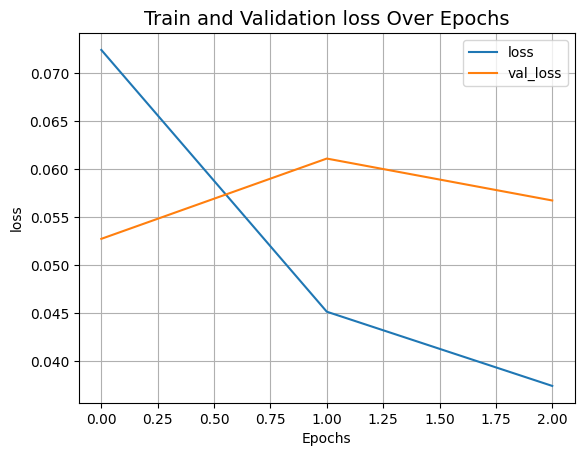

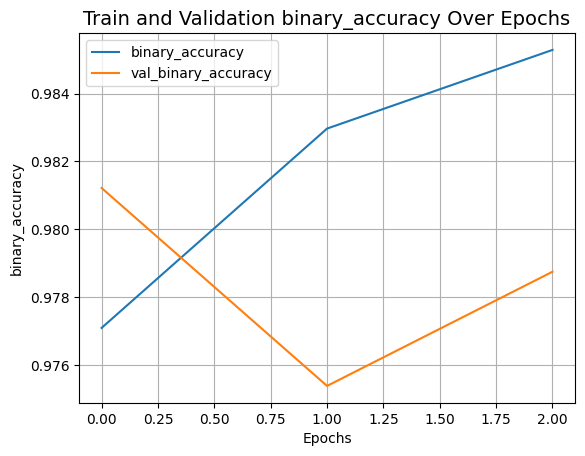

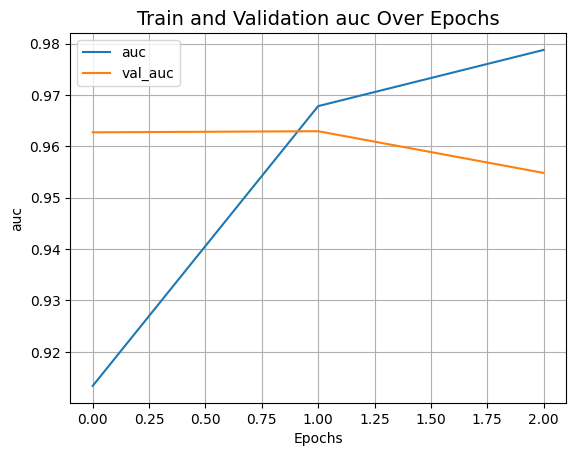

In [ ]:
train_model(model_positional, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

AUC score

In [ ]:
model_positional.evaluate(ds_test)

1000/1000 [==============================] - 25s 25ms/step - loss: 0.0889 - binary_accuracy: 0.9646 - auc: 0.9561


[0.08888242393732071, 0.9646283388137817, 0.9560859799385071]

Classification report and confusion matrices

1000/1000 [==============================] - 23s 23ms/step
ROC AUC Score per Label	 [0.95921031 0.98193443 0.97377569 0.94075183 0.96326569 0.93996565]
Micro ROC AUC Score	 0.9730935387880099
Macro ROC AUC Score	 0.9598172654153835
Weighted ROC AUC Score	 0.9632385488163995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        toxic       0.49      0.88      0.63      6090
 severe_toxic       0.30      0.42      0.35       367
      obscene       0.64      0.71      0.68      3691
       threat       0.00      0.00      0.00       211
       insult       0.51      0.68      0.58      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.52      0.72      0.61     14498
    macro avg       0.32      0.45      0.37     14498
 weighted avg       0.50      0.72      0.58     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9027 - Recall: 0.8798 - Precision: 0.4939 - F1 score: 0.6326


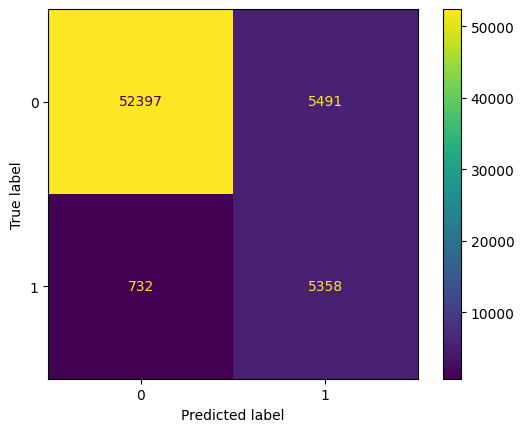

severe_toxic - Acc: 0.9910 - Recall: 0.4196 - Precision: 0.2979 - F1 score: 0.3484


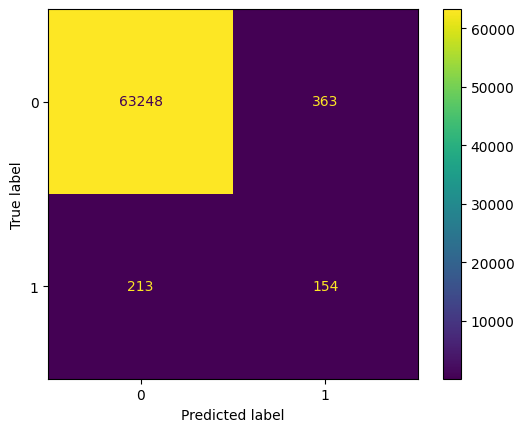

obscene - Acc: 0.9606 - Recall: 0.7147 - Precision: 0.6423 - F1 score: 0.6766


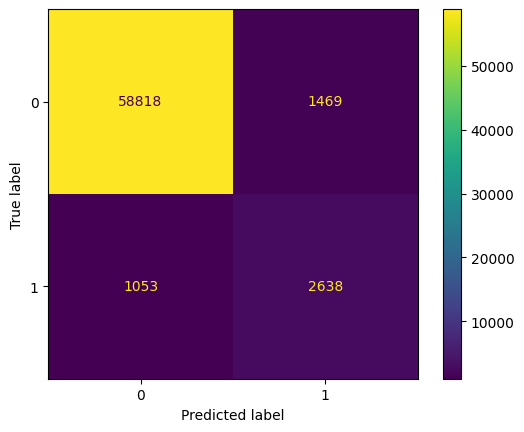

<ipython-input-24-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


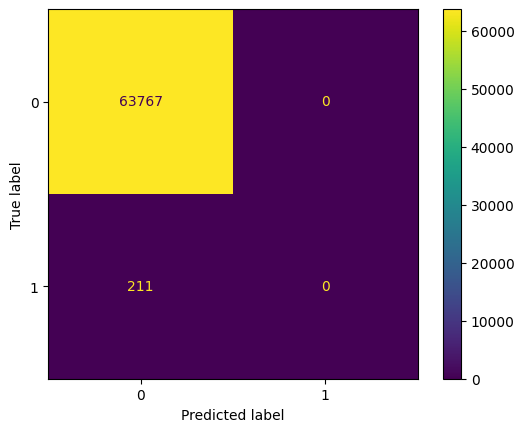

insult - Acc: 0.9479 - Recall: 0.6831 - Precision: 0.5101 - F1 score: 0.5841


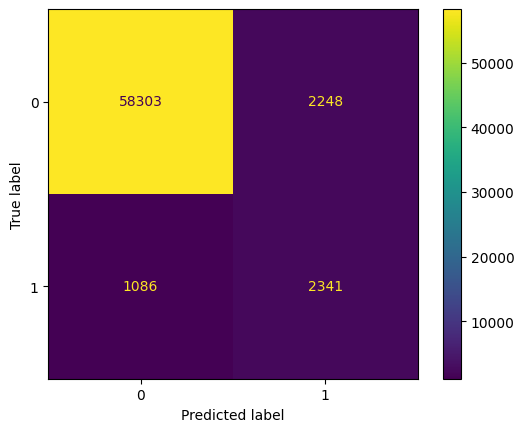

identity_hate - Acc: 0.9889 - Recall: 0.0000 - Precision: nan - F1 score: nan


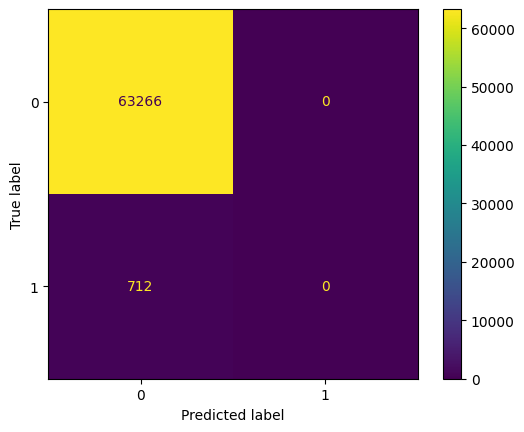

In [ ]:
mp_preds = model_metrics(model_positional)

Print of misclassified `threat` insults

In [ ]:
all_zero_predictions = model_comments(3, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwi

Print of misclassified `identity hate` insults

In [ ]:
all_zero_predictions = model_comments(5, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g

### GLOVE (FROZEN WEIGHTS)

Epoch 1/20
1995/1995 [==============================] - 133s 65ms/step - loss: 0.0637 - binary_accuracy: 0.9784 - auc: 0.9422 - val_loss: 0.0548 - val_binary_accuracy: 0.9809 - val_auc: 0.9580
Epoch 2/20
1995/1995 [==============================] - 129s 65ms/step - loss: 0.0549 - binary_accuracy: 0.9804 - auc: 0.9579 - val_loss: 0.0525 - val_binary_accuracy: 0.9812 - val_auc: 0.9596
Epoch 3/20
1995/1995 [==============================] - 129s 64ms/step - loss: 0.0524 - binary_accuracy: 0.9810 - auc: 0.9638 - val_loss: 0.0520 - val_binary_accuracy: 0.9813 - val_auc: 0.9558


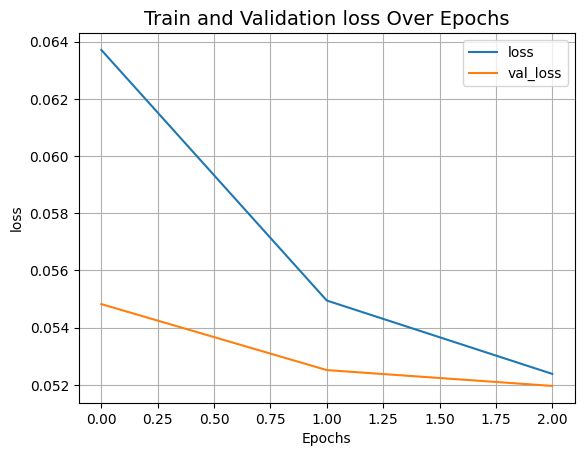

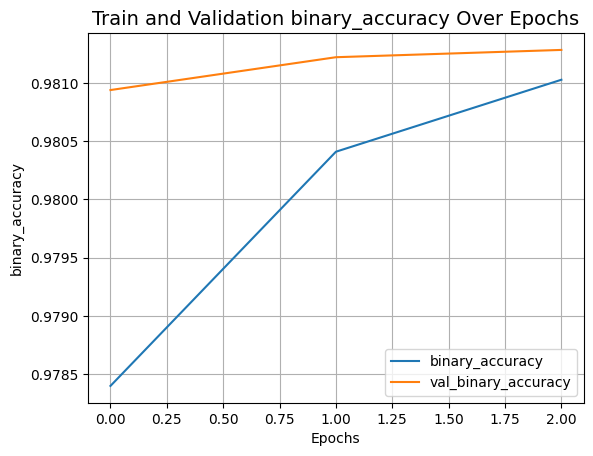

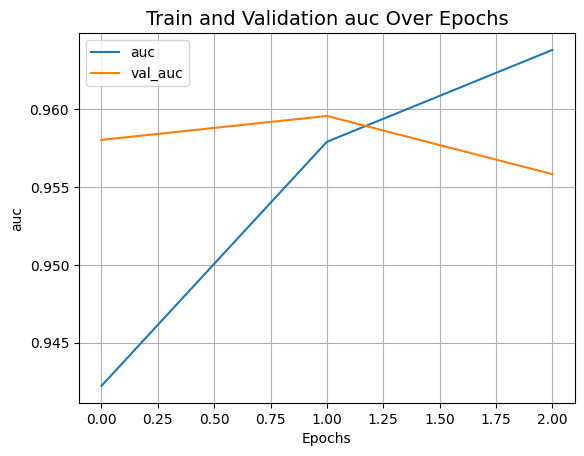

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [ ]:
model_glove.evaluate(ds_test)

1000/1000 [==============================] - 23s 23ms/step - loss: 0.0807 - binary_accuracy: 0.9683 - auc: 0.9586


[0.08072124421596527, 0.9682777523994446, 0.9586355090141296]

1000/1000 [==============================] - 22s 22ms/step
ROC AUC Score per Label	 [0.95109734 0.9808888  0.96397926 0.96950569 0.96177942 0.967937  ]
Micro ROC AUC Score	 0.9709793240243789
Macro ROC AUC Score	 0.9658645839813667
Weighted ROC AUC Score	 0.9587509552232181


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        toxic       0.54      0.79      0.64      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.61      0.69      0.65      3691
       threat       0.00      0.00      0.00       211
       insult       0.57      0.68      0.62      3427
identity_hate       0.62      0.12      0.19       712

    micro avg       0.57      0.67      0.62     14498
    macro avg       0.39      0.38      0.35     14498
 weighted avg       0.55      0.67      0.59     14498
  samples avg       0.07      0.06      0.06     14498

toxic - Acc: 0.9167 - Recall: 0.7944 - Precision: 0.5426 - F1 score: 0.6448


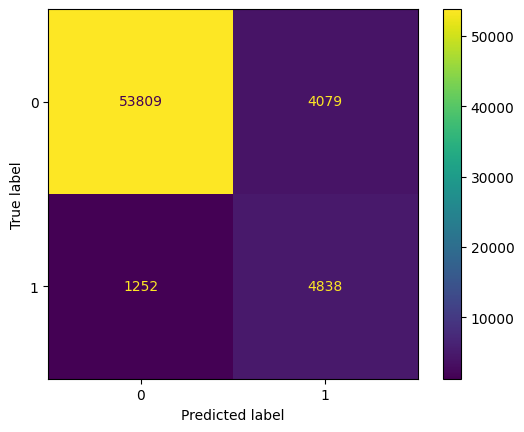

<ipython-input-24-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


severe_toxic - Acc: 0.9943 - Recall: 0.0000 - Precision: nan - F1 score: nan


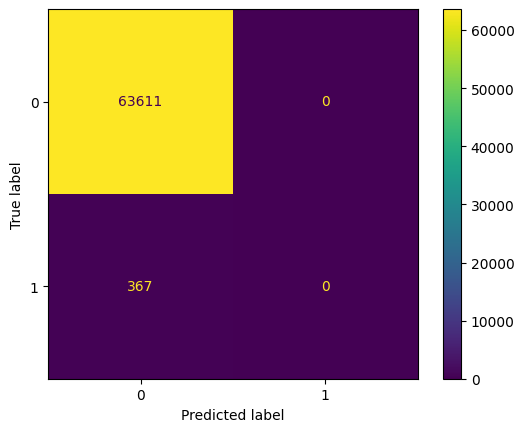

obscene - Acc: 0.9570 - Recall: 0.6865 - Precision: 0.6143 - F1 score: 0.6484


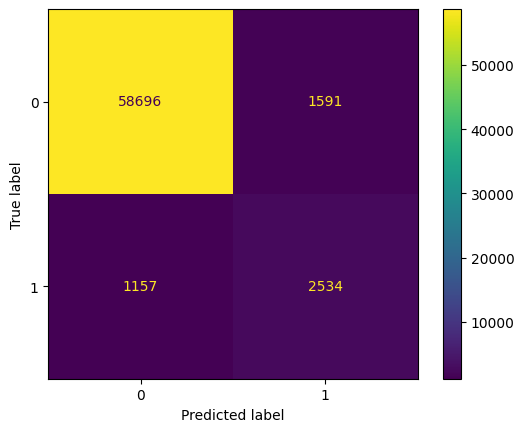

threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


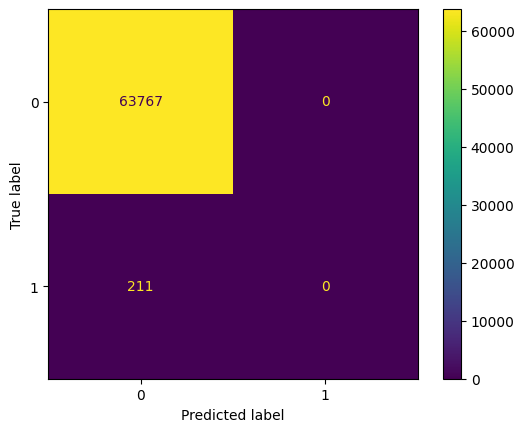

insult - Acc: 0.9556 - Recall: 0.6764 - Precision: 0.5725 - F1 score: 0.6201


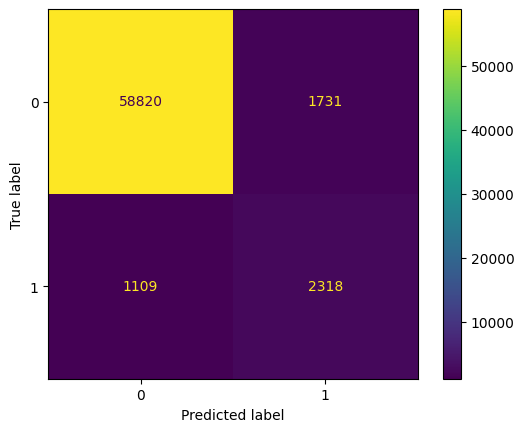

identity_hate - Acc: 0.9894 - Recall: 0.1152 - Precision: 0.6212 - F1 score: 0.1943


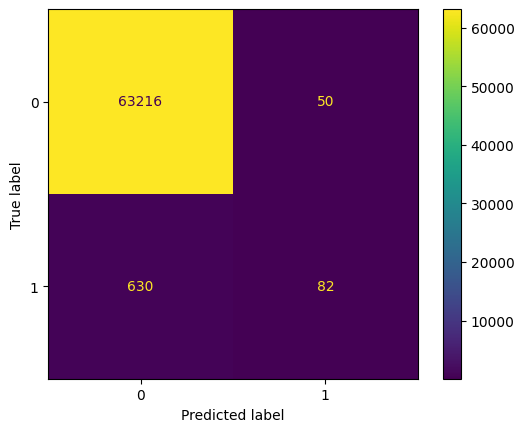

In [ ]:
mg_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mg_preds)
print(f'Percentage of all-zero predictions: {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwi

In [ ]:
all_zero_predictions = model_comments(5, mg_preds)
print(f'Percentage of all-zero predictions: {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g

### GLOVE (TRAINABLE WEIGHTS)

In [ ]:
embedding_layer_glove.trainable = True
model_glove.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

Epoch 1/20
1995/1995 [==============================] - 256s 127ms/step - loss: 0.0515 - binary_accuracy: 0.9812 - auc: 0.9630 - val_loss: 0.0498 - val_binary_accuracy: 0.9820 - val_auc: 0.9663
Epoch 2/20
1995/1995 [==============================] - 164s 82ms/step - loss: 0.0476 - binary_accuracy: 0.9822 - auc: 0.9707 - val_loss: 0.0488 - val_binary_accuracy: 0.9820 - val_auc: 0.9674
Epoch 3/20
1995/1995 [==============================] - 164s 82ms/step - loss: 0.0446 - binary_accuracy: 0.9829 - auc: 0.9754 - val_loss: 0.0484 - val_binary_accuracy: 0.9822 - val_auc: 0.9671


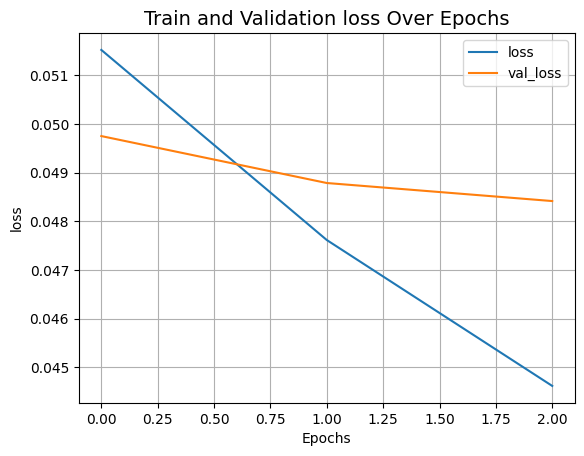

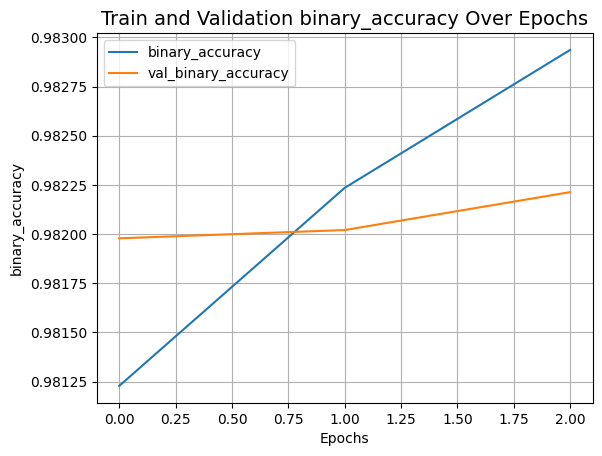

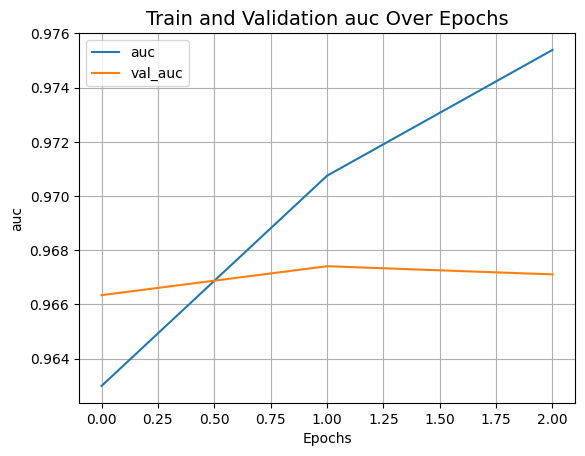

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [ ]:
model_glove.evaluate(ds_test)

1000/1000 [==============================] - 24s 24ms/step - loss: 0.0767 - binary_accuracy: 0.9695 - auc: 0.9655


[0.07666302472352982, 0.9695290327072144, 0.9654950499534607]

1000/1000 [==============================] - 22s 22ms/step
ROC AUC Score per Label	 [0.95831629 0.98303095 0.96939441 0.97834244 0.96639426 0.97365063]
Micro ROC AUC Score	 0.9761623586817166
Macro ROC AUC Score	 0.971521497066739
Weighted ROC AUC Score	 0.9647162357544943
               precision    recall  f1-score   support

        toxic       0.55      0.83      0.66      6090
 severe_toxic       0.34      0.38      0.36       367
      obscene       0.64      0.71      0.67      3691
       threat       0.00      0.00      0.00       211
       insult       0.58      0.71      0.64      3427
identity_hate       0.64      0.38      0.47       712

    micro avg       0.58      0.73      0.64     14498
    macro avg       0.46      0.50      0.47     14498
 weighted avg       0.57      0.73      0.63     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9200 - Recall: 0.8284 - Precision: 0.5534 - F1 score: 0.6635


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


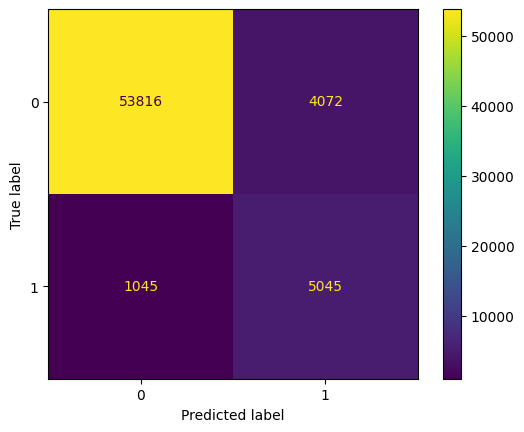

severe_toxic - Acc: 0.9922 - Recall: 0.3787 - Precision: 0.3415 - F1 score: 0.3592


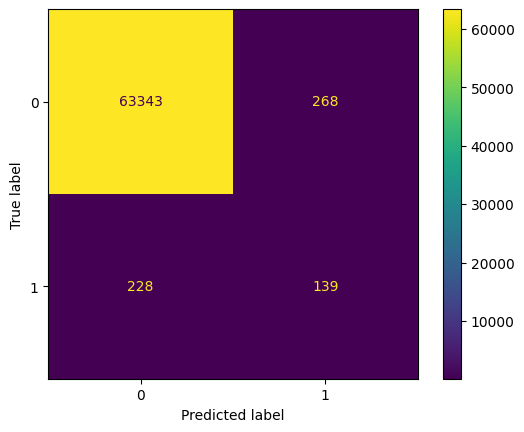

obscene - Acc: 0.9603 - Recall: 0.7147 - Precision: 0.6391 - F1 score: 0.6748


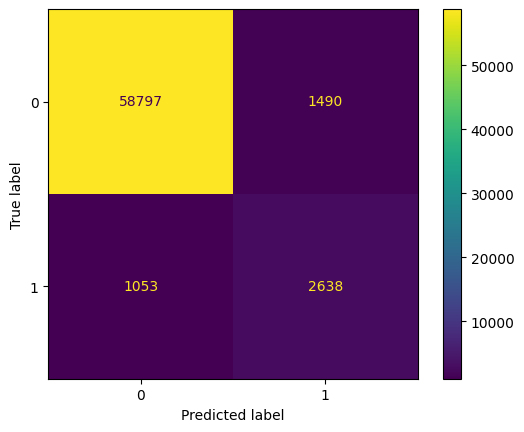

<ipython-input-24-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


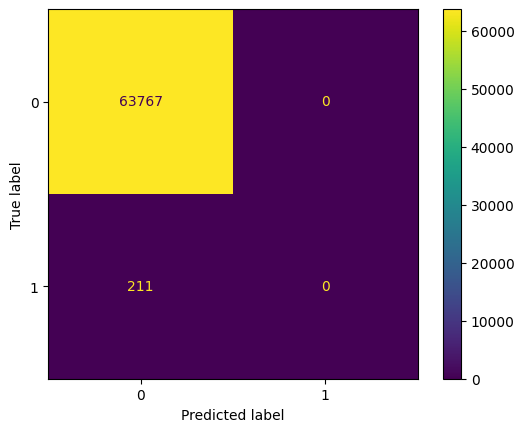

insult - Acc: 0.9573 - Recall: 0.7064 - Precision: 0.5834 - F1 score: 0.6390


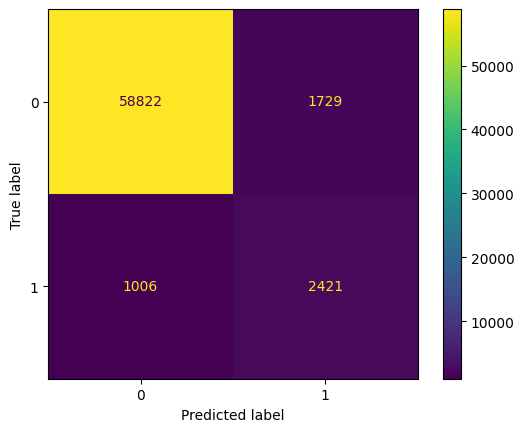

identity_hate - Acc: 0.9907 - Recall: 0.3778 - Precision: 0.6390 - F1 score: 0.4748


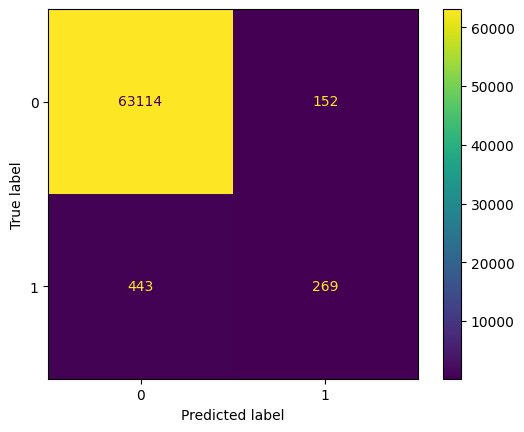

In [ ]:
mgt_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mgt_preds)
print(f'Percentage of all-zero predictions: {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwikithe_real_stephen_hawkinghttpenwikipediaorgwi

In [ ]:
all_zero_predictions = model_comments(5, mgt_preds)
print(f'Percentage of all-zero predictions: {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g